# SoPEM Fitter v1
Questo notebook contiene lo script di apprendimento e previsione per SoPEM.
In base ai valori precedenti di PM10 nella località più vicina possiamo calibrare il sensore tramite
tecniche di machine learning.

I dati reali di PM10 sono prelevati dal sito di ARPA Piemonte (http://www.arpa.piemonte.it/approfondimenti/temi-ambientali/aria/aria/semaforo-qualita-dellaria-pm10)

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import json

In [2]:
reference_city = 'CASALE MONFERRATO'

In [3]:
ds_real_pm10 = pd.read_csv('https://raw.githubusercontent.com/is-sobrero/pm10-ml/master/datasets/arpa_pm10-20200618%20-%20arpa_pm10-20200618.csv')
sense_pm10 = pd.read_csv('https://raw.githubusercontent.com/is-sobrero/pm10-ml/master/datasets/pontestura_pm10.csv')
pm10_arpa = ds_real_pm10.melt(id_vars=['PROVINCIA', 'CITTA'], var_name="DATA", value_name="PM10")

In [10]:
sense_pm10.columns
pm10_arpa.columns

Index(['PROVINCIA', 'CITTA', 'DATA', 'PM10'], dtype='object')

In [14]:
filtered_realpm10 = pm10_arpa.loc[(pm10_arpa['CITTA'] == reference_city) & (pm10_arpa['PM10'] > -1)]
filtered_realpm10.columns = ['RIF_PROV', 'RIF_CITTA', 'DATA', 'RIF_PM10']

filtered_senspm10 = sense_pm10.loc[sense_pm10['RIFERIMENTO'] == reference_city]
filtered_senspm10.columns = ['SEN_PROV', 'SEN_CITTA', 'RIF_CITTA', 'DATA', 'ORARIO', 'AVG_SENSORE']

final_dataset = pd.merge(filtered_realpm10, filtered_senspm10, how='outer', on=['DATA', 'RIF_CITTA']).dropna()
final_dataset

,RIF_PROV,RIF_CITTA,DATA,RIF_PM10,SEN_PROV,SEN_CITTA,ORARIO,AVG_SENSORE
12,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,19.0,5.42
13,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,20.0,5.27
14,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,21.0,12.76
15,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,22.0,12.81
16,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,23.0,12.67
17,AL,CASALE MONFERRATO,24/06,19.0,AL,PONTESTURA,0.0,5.99
18,AL,CASALE MONFERRATO,24/06,19.0,AL,PONTESTURA,1.0,5.95
19,AL,CASALE MONFERRATO,24/06,19.0,AL,PONTESTURA,2.0,5.74
20,AL,CASALE MONFERRATO,24/06,19.0,AL,PONTESTURA,3.0,4.46
21,AL,CASALE MONFERRATO,24/06,19.0,AL,PONTESTURA,4.0,3.63


In [15]:
final_dataset.head()

,RIF_PROV,RIF_CITTA,DATA,RIF_PM10,SEN_PROV,SEN_CITTA,ORARIO,AVG_SENSORE
12,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,19.0,5.42
13,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,20.0,5.27
14,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,21.0,12.76
15,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,22.0,12.81
16,AL,CASALE MONFERRATO,22/06,15.0,AL,PONTESTURA,23.0,12.67


In [20]:
y = final_dataset['RIF_PM10'].values.reshape(-1,1)
x = final_dataset['AVG_SENSORE'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [21]:
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_pred = linear_regressor.predict(x_test)

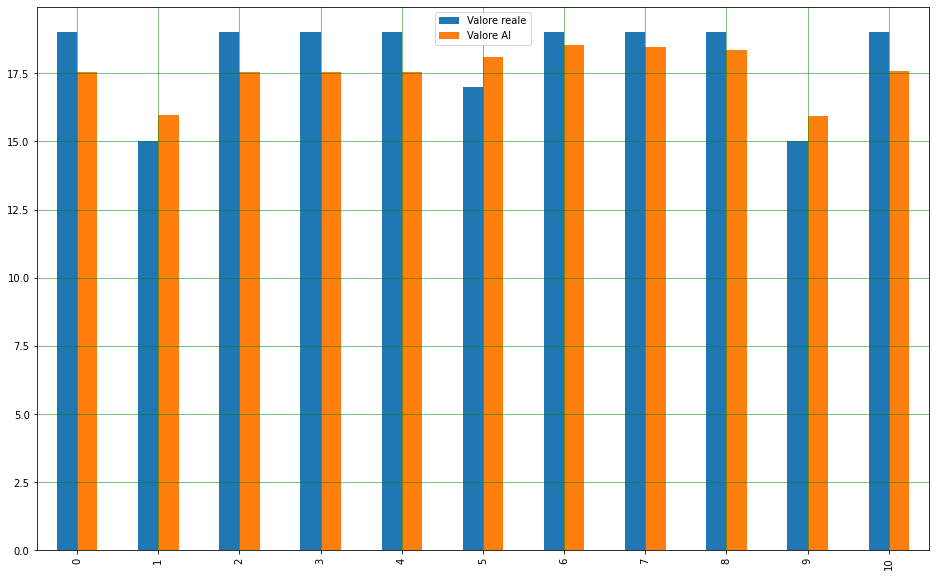

In [48]:
df = pd.DataFrame({'Valore reale': y_test.flatten(), 'Valore AI': y_pred.flatten()})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [74]:
accuracy = np.mean(abs(y_test - y_pred) < 1.45)

eq_m = linear_regressor.coef_.item()
eq_q = linear_regressor.intercept_.item()
print("Accuratezza modello: {:.2f}%".format(accuracy*100))

sample_obj = {"sensor": {
		"reference_voltage":1.75,
		"linear_m": round(eq_m, 2),
		"linear_q": round(eq_q, 2)
	}}

print("Pendenza retta (m): {:.2f}".format(eq_m))
print("Pendenza retta (q): {:.2f}".format(eq_q))
print("\nEsempio di oggetto per il file config.json:")
print(json.dumps(sample_obj, indent=2, sort_keys=True))

Accuratezza modello: 72.73%
Pendenza retta (m): -0.28
Pendenza retta (q): 19.45

Esempio di oggetto per il file config.json:
{
  "sensor": {
    "linear_m": -0.28,
    "linear_q": 19.45,
    "reference_voltage": 1.75
  }
}
